<a href="https://colab.research.google.com/github/emiliomercuri/ciencia_dados/blob/main/aulas/2023_11_22_Aula_11_PyTorch_(Classifica%C3%A7%C3%A3o_multi_classes).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aula 11 - PyTorch (Classificação multi-classes)

Iremos trabalhar hoje com Redes Neurais Artificiais (RNA) para classificação. Alguns tipos de classificação:

* Classificação binária (tema da última aula)
* Classificação multi-classe (tema da aula de hoje)



## Criando um data-set com multi-classes

In [1]:
# bibliotecas
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

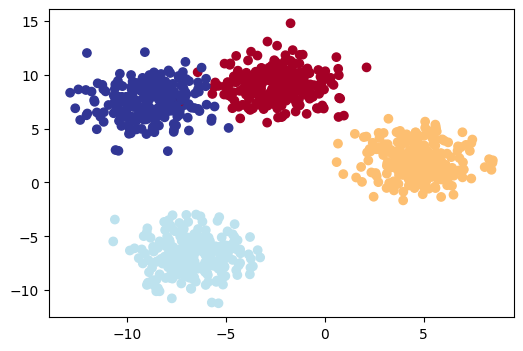

In [166]:
# Criando dados
X_blob, y_blob = make_blobs(n_samples = 1000,
                            n_features = 2,
                            centers = 4,
                            cluster_std = 1.5,
                            random_state=42)

# Transformando os dados em tensores
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# Dividir os dados em treinamento e teste
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=42)
# Visualizar os dados
plt.figure(figsize=(6,4))
plt.scatter(X_blob[:,0], X_blob[:,1],c=y_blob,cmap=plt.cm.RdYlBu);

In [167]:
# Código independente do dispositivo
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Construindo o nosso modelo de classificação multi-classes com PyTorch

In [168]:
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self,x):
    return self.linear_layer_stack(x)

# Instanciar uma instância do BlobModel e enviar para o target device (unidade de processamento)
model_4 = BlobModel(input_features=2,
                    output_features=4,
                    hidden_units=8).to(device)

model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)


<img src="https://www.dropbox.com/scl/fi/fqagap9cxbsnxxyruydda/activation_function.png?rlkey=o8hoiuhmwh59942reapvbv6az&dl=1" width="700"/>

In [169]:
X_blob_train.shape, y_blob_train.shape, y_blob_train[:5]

(torch.Size([800, 2]), torch.Size([800]), tensor([1, 0, 2, 2, 0]))

In [170]:
# # Visualizar os dados
# plt.figure(figsize=(6,4))
# plt.scatter(X_blob_train[:,0], X_blob_train[:,1],c=y_blob_train,cmap=plt.cm.RdYlBu);

In [171]:
# # Visualizar os dados
# plt.figure(figsize=(6,4))
# plt.scatter(X_blob_test[:,0], X_blob_test[:,1],c=y_blob_test,cmap=plt.cm.RdYlBu);

In [172]:
torch.unique(y_blob_train)

tensor([0, 1, 2, 3])

## Criando a função perda (critério) e otimizador

In [173]:
# Criando a função perda/custo (critério)
loss_fn = nn.CrossEntropyLoss()

# Criando um otimizador
optimizer = torch.optim.SGD(params=model_4.parameters(),
                            lr=0.1)

In [174]:
#from sklearn.metrics import accuracy_score

## Obtendo probabilidades das predições para o nosso modelo multi-classe

**Logits** são as saídas da nossa rede neural. São as probabilidades não normalizadas de um item pertencente a uma determinada classe. Logits são frequentemente usados em tarefas de classificação, onde o objetivo é prever o rótulo da classe de uma entrada.

* Referência para leitura: https://wandb.ai/amanarora/Written-Reports/reports/Understanding-Logits-Sigmoid-Softmax-and-Cross-Entropy-Loss-in-Deep-Learning--Vmlldzo0NDMzNTU3

O resultado bruto do nosso modelo atual são logits e precisamos calcular as probabilidades das predições e converter as probabilidades em labels (rótulos).

Logits (saída do modelo) -> probabilidades (usando `torch.softmax`) -> rótulos (labels) (usando `argmax` das probabilidades)

In [175]:
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test.to(device))

y_logits[:10]

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834],
        [-0.1497, -1.0617, -0.7107, -0.1645],
        [ 0.1539, -0.2887,  0.1520, -0.0109],
        [-0.2154, -1.1795, -0.9300, -0.2745],
        [ 0.2443, -0.2472,  0.1649,  0.0061],
        [-0.2329, -1.2120, -0.9849, -0.3004]], device='cuda:0')

In [176]:
y_blob_test[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

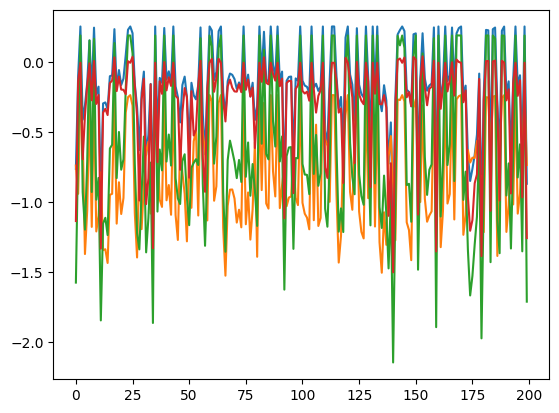

In [177]:
plt.plot(y_logits.cpu());

In [178]:
#plt.plot(y_pred_probs.cpu());

In [179]:
# Convertendo as saídas logits do modelo para probabilidade estatísticas
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]], device='cuda:0')
tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]], device='cuda:0')


In [180]:
torch.sum(y_pred_probs[0])

tensor(1., device='cuda:0')

In [181]:
torch.max(y_pred_probs[0])

tensor(0.3244, device='cuda:0')

In [182]:
torch.argmax(y_pred_probs[0])

tensor(1, device='cuda:0')

In [183]:
y_preds = torch.argmax(y_pred_probs,dim=1)
y_preds

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')

In [184]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1])

In [185]:
# Calculate accuracy - out of 100 examples, what percentage does our model get right?
def accuracy_fn(y_true, y_pred):
  # torch.eq sees by boolean comparison how the arguments are equal, then we do the sum and get the single value
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100 # accuracy
  return acc

##  Construindo um laço de repetição para treinamento e teste

In [186]:
y_blob_train.shape, y_logits.shape

(torch.Size([800]), torch.Size([200, 4]))

In [187]:
# Escolhendo uma semente aleatória
torch.manual_seed(42)
torch.cuda.manual_seed(42)
# Definindo o número de épocas
epochs = 100

# Enviando os dados para o dispositivo (cuda)
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

# Loop
for epoch in range(epochs):
  ### Training
  model_4.train()

  y_logits = model_4(X_blob_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_true = y_blob_train, y_pred = y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  ### Testing
  model_4.eval()
  with torch.inference_mode():
    test_logits = model_4(X_blob_test)
    test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_true = y_blob_test, y_pred = test_preds)

  # Imprimir o que está acontecendo
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.5f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.5f}%")


Epoch: 0 | Loss: 1.15883, Acc: 40.37500% | Test loss: 1.07554, Test acc: 48.00000%
Epoch: 10 | Loss: 0.64476, Acc: 96.75000% | Test loss: 0.66069, Test acc: 97.50000%
Epoch: 20 | Loss: 0.42535, Acc: 98.50000% | Test loss: 0.43074, Test acc: 100.00000%
Epoch: 30 | Loss: 0.25294, Acc: 99.12500% | Test loss: 0.24508, Test acc: 99.50000%
Epoch: 40 | Loss: 0.11232, Acc: 99.25000% | Test loss: 0.10229, Test acc: 99.50000%
Epoch: 50 | Loss: 0.06627, Acc: 99.25000% | Test loss: 0.05848, Test acc: 99.50000%
Epoch: 60 | Loss: 0.05068, Acc: 99.25000% | Test loss: 0.04293, Test acc: 99.50000%
Epoch: 70 | Loss: 0.04300, Acc: 99.25000% | Test loss: 0.03491, Test acc: 99.50000%
Epoch: 80 | Loss: 0.03836, Acc: 99.25000% | Test loss: 0.02988, Test acc: 99.50000%
Epoch: 90 | Loss: 0.03525, Acc: 99.25000% | Test loss: 0.02663, Test acc: 99.50000%


## Avaliando as predições do nosso modelo de classificação multi-classes

In [188]:
# Fazendo a avaliação
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test)

y_logits[:10]

tensor([[-0.6249,  5.9860, -7.6323, -8.4470],
        [-2.1738, -6.3750, -3.7202,  3.1203],
        [-3.4102, -3.8958,  3.1567, -2.6119],
        [-1.1505,  4.1962, -3.8472, -4.8820],
        [ 3.7548, -1.3391, -9.1422, -6.9466],
        [-2.8211, -7.5767, -4.2944,  3.7944],
        [-3.0306, -3.3328,  2.7955, -2.1374],
        [ 3.3761, -4.0375, -6.8987, -3.5503],
        [-4.3620, -4.9904,  3.8123, -3.3814],
        [ 3.5012, -3.0281, -7.5401, -4.7064]], device='cuda:0')

In [189]:
# Go from logits -> Prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10]

tensor([[1.3438e-03, 9.9865e-01, 1.2164e-06, 5.3854e-07],
        [4.9905e-03, 7.4740e-05, 1.0630e-03, 9.9387e-01],
        [1.3985e-03, 8.6060e-04, 9.9463e-01, 3.1073e-03],
        [4.7389e-03, 9.9483e-01, 3.1956e-04, 1.1353e-04],
        [9.9388e-01, 6.0966e-03, 2.4904e-06, 2.2378e-05],
        [1.3372e-03, 1.1504e-05, 3.0644e-04, 9.9834e-01],
        [2.9138e-03, 2.1537e-03, 9.8781e-01, 7.1181e-03],
        [9.9838e-01, 6.0198e-04, 3.4435e-05, 9.7989e-04],
        [2.8147e-04, 1.5016e-04, 9.9882e-01, 7.5044e-04],
        [9.9825e-01, 1.4575e-03, 1.5998e-05, 2.7210e-04]], device='cuda:0')

In [190]:
# Go from pred probs to pred labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 0, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1], device='cuda:0')

In [191]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1], device='cuda:0')

## Visualizar

In [192]:
import requests
from pathlib import Path

# Download helper functions from ciencia_dados repo (if it's not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/emiliomercuri/ciencia_dados/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


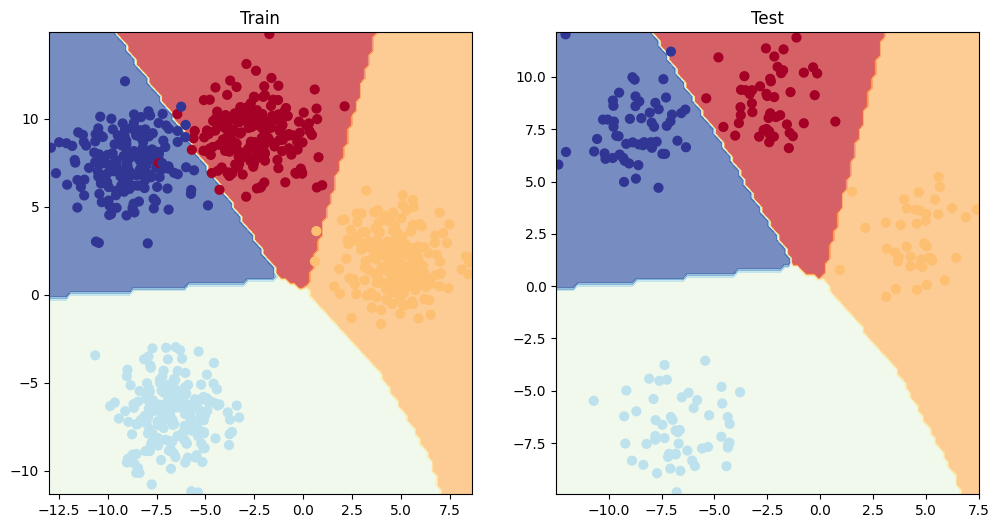

In [193]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)